load the dataset

In [1]:
!pip install --quiet ONE-api ibllib

from one.api import ONE
import numpy as np

ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

# Get dataset for behavior trials
datasets = one.alyx.rest('datasets', 'list',
                         tag='2021_Q1_IBL_et_al_Behaviour',
                         name='_ibl_subjectTrials.table.pqt')
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])
print(f"Found {len(subjects)} subjects.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.5/994.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.7/100.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.0/206.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.6 MB/s eta 0:

In [21]:
def load_subject_data(subject):
    print(f"Loading data for subject: {subject}")
    subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
    session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')
    session_trials = session_trials.drop(columns=['task_protocol'], errors='ignore')
    subject_trials = subject_trials[subject_trials['task_protocol'] == 'biasedChoiceWorld']

    # Join on session index
    subject_trials = subject_trials.set_index('session').join(
        session_trials.drop(columns=['date'], errors='ignore')
    )
    subject_trials['subject'] = subject
    return subject_trials

In [42]:
subject = "ibl_witten_15"
print(f"Loading data for subject: {subject}")

subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')
print(len(subject_trials))
print(len(session_trials))

Loading data for subject: ibl_witten_15
87835
87


In [22]:
import pandas as pd

In [23]:
pretrain_subjects = ["ibl_witten_12", "ibl_witten_13", "ibl_witten_14"]
target_subject = "ibl_witten_15"  # your fine-tune mouse
all_trials = []
for subj in pretrain_subjects:
    df = load_subject_data(subj)
    all_trials.append(df)
df_pretrain = pd.concat(all_trials)
print(f"Pretraining data loaded: {len(df_pretrain)} trials from {len(pretrain_subjects)} mice")

Loading data for subject: ibl_witten_12
Loading data for subject: ibl_witten_13


/usr/local/lib/python3.11/dist-packages/one/api.py:1937: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['identifier'] = records['rel_path'].map(path2id)


Loading data for subject: ibl_witten_14
Pretraining data loaded: 179820 trials from 3 mice


In [24]:
# Step 2: Feature Engineering Function
def compute_features(df):
    df = df.copy()
    df['reaction_time'] = df['response_times'] - df['stimOn_times']
    df['iti'] = df['goCue_times'].diff().fillna(0)#inter trial interval
    df['block_id'] = (df.reset_index().index // 50).astype(int)  # 50-trial blocks
    df['correct'] = (df['feedbackType'] == 1).astype(int)
    df['performance_block'] = df.groupby('block_id')['correct'].transform('mean')
    df['performance_drop'] = df['performance_block'].diff().fillna(0)
    return df
df_pretrain = compute_features(df_pretrain)


subject selection # i used the one subject only i train the model on all the subject which has biasedchoiceworld but i don't understand why the resulting session is less

In [25]:
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [26]:
print(df_pretrain.columns)


Index(['intervals_0', 'intervals_1', 'goCue_times', 'response_times', 'choice',
       'stimOn_times', 'contrastLeft', 'contrastRight', 'feedback_times',
       'feedbackType', 'rewardVolume', 'probabilityLeft',
       'firstMovement_times', 'goCueTrigger_times', 'stimOnTrigger_times',
       'stimOffTrigger_times', 'stimFreezeTrigger_times', 'stimOff_times',
       'stimFreeze_times', 'phase', 'position', 'quiescence', 'task_protocol',
       'protocol_number', 'session_start_time', 'lab', 'subject', 'number',
       'projects', 'reaction_time', 'iti', 'block_id', 'correct',
       'performance_block', 'performance_drop'],
      dtype='object')


In [27]:
# Step 3: Compute Continuous Boredom Score
def compute_boredom_score(df):
    df = df.copy()
    rt_smooth = gaussian_filter1d(df['reaction_time'].fillna(0), sigma=5)
    perf_drop = df['performance_drop'].fillna(0)

    scaler = StandardScaler()
    rt_z = scaler.fit_transform(rt_smooth.reshape(-1, 1)).flatten()
    drop_z = scaler.fit_transform(perf_drop.values.reshape(-1, 1)).flatten()

    boredom = 0.5 * rt_z + 0.5 * drop_z
    df['boredom_score'] = boredom
    return df

df_pretrain = df_pretrain.groupby(['subject', 'number']).apply(compute_boredom_score)

<ipython-input-27-fe7cdfcaf091>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pretrain = df_pretrain.groupby(['subject', 'number']).apply(compute_boredom_score)


In [28]:
features = ['reaction_time', 'iti', 'block_id', 'performance_drop']
X_pretrain = df_pretrain[features]
y_pretrain = df_pretrain['boredom_score']

print("Training RandomForestRegressor on pretraining mice...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_pretrain, y_pretrain)

Training RandomForestRegressor on pretraining mice...


RandomForestRegressor(random_state=0)

In [34]:
df_target = load_subject_data(target_subject)
print(df_target.shape)
print(df_target.columns)
df_target = compute_features(df_target)
df_target = df_target.groupby('number').apply(compute_boredom_score)

X_target = df_target[features]
y_target = df_target['boredom_score']


Loading data for subject: ibl_witten_15
(68734, 29)
Index(['intervals_0', 'intervals_1', 'goCue_times', 'response_times', 'choice',
       'stimOn_times', 'contrastLeft', 'contrastRight', 'feedback_times',
       'feedbackType', 'rewardVolume', 'probabilityLeft',
       'firstMovement_times', 'goCueTrigger_times', 'stimOnTrigger_times',
       'stimOffTrigger_times', 'stimFreezeTrigger_times', 'stimOff_times',
       'stimFreeze_times', 'phase', 'position', 'quiescence', 'task_protocol',
       'protocol_number', 'session_start_time', 'lab', 'subject', 'number',
       'projects'],
      dtype='object')


<ipython-input-34-d8a3b61181f9>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_target = df_target.groupby('number').apply(compute_boredom_score)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_target, y_target, test_size=0.2, random_state=42)

In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(54987, 4)
(13747, 4)
(54987,)
(13747,)


In [32]:
print("Fine-tuning model on target mouse data...")
rf_model.fit(X_train, y_train)

# Step 7: Evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on target mouse test set after fine-tuning: {mae:.4f}")

Fine-tuning model on target mouse data...
MAE on target mouse test set after fine-tuning: 0.1529


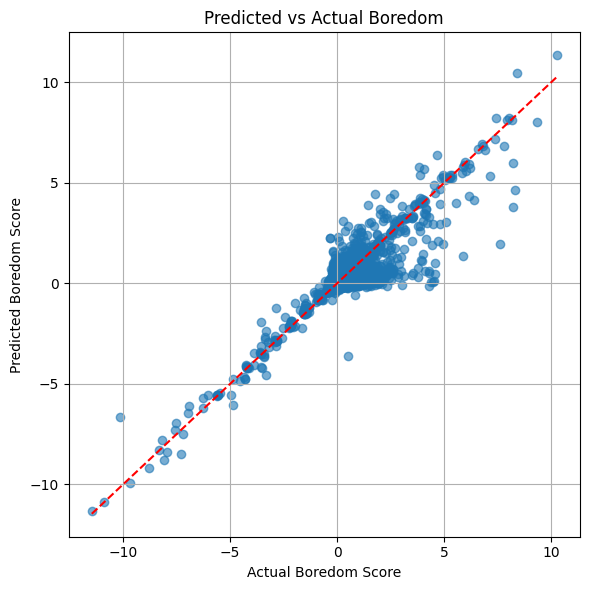

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # y = x line

plt.xlabel('Actual Boredom Score')
plt.ylabel('Predicted Boredom Score')
plt.title('Predicted vs Actual Boredom')
plt.grid(True)
plt.tight_layout()
plt.show()


just random try

In [ ]:
# Get all sessions with biasedChoiceWorld task
all_sessions = one.alyx.rest('sessions', 'list', task_protocol='biasedChoiceWorld')

# Extract unique subjects from these sessions
subjects = np.unique([sess['subject'] for sess in all_sessions])

# Count biasedChoiceWorld sessions per subject
subject_session_counts = {}
for subj in subjects:
    subj_sessions = [sess for sess in all_sessions if sess['subject'] == subj]
    subject_session_counts[subj] = len(subj_sessions)

# Print results
print("Number of biasedChoiceWorld sessions per subject:")
for subj, count in subject_session_counts.items():
    print(f"{subj}: {count}")

# Find subject with max sessions
max_subject = max(subject_session_counts, key=subject_session_counts.get)
max_count = subject_session_counts[max_subject]
print(f"\nSubject with the most biasedChoiceWorld sessions: {max_subject} ({max_count} sessions)")

Number of biasedChoiceWorld sessions per subject:
CSHL045: 23
CSHL046: 26
CSHL047: 20
CSHL049: 17
CSHL051: 29
CSHL052: 15
CSHL053: 18
CSHL054: 32
CSHL055: 25
CSHL058: 4
CSHL059: 12
CSHL060: 18
CSHL_001: 12
CSHL_002: 13
CSHL_003: 11
CSHL_005: 2
CSHL_007: 13
CSHL_008: 6
CSHL_010: 10
CSHL_011: 1
CSHL_012: 40
CSHL_013: 1
CSHL_014: 55
CSHL_015: 49
CSH_ZAD_001: 26
CSH_ZAD_002: 33
CSH_ZAD_003: 14
CSH_ZAD_004: 14
CSH_ZAD_005: 30
CSH_ZAD_006: 7
CSH_ZAD_007: 12
CSH_ZAD_010: 11
CSH_ZAD_011: 26
CSH_ZAD_022: 3
DY_001: 3
DY_002: 3
DY_003: 3
DY_005: 15
DY_006: 26
DY_007: 24
DY_008: 17
DY_009: 11
DY_010: 34
DY_011: 39
DY_013: 16
DY_014: 4
IBL-T1: 39
IBL-T2: 33
IBL-T3: 34
IBL-T4: 41
IBL_001: 5
IBL_002: 17
IBL_005: 2
KS002: 24
KS004: 21
KS005: 21
KS014: 30
KS015: 29
KS016: 26
KS017: 30
KS018: 1
KS019: 65
KS021: 41
KS022: 25
KS023: 27
KS024: 30
KS025: 10
NYU-01: 51
NYU-02: 53
NYU-04: 52
NYU-06: 46
NYU-07: 7
NYU-09: 43
NYU-11: 20
NYU-12: 14
NYU-13: 23
NYU-14: 28
NYU-20: 22
SWC_001: 26
SWC_002: 1
SWC_013: 

boredom score computation